In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
import re
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import seaborn as sns

In [53]:
# Import the data

demographics = pd.read_csv('new_Data/demographics_4_Guilia.csv')

ROIs = pd.read_csv("new_Data/dka_HCP_test.csv")
ROIs = ROIs["name"]
columns = [ROI + "_" + str(j/2) for ROI in ROIs for j in range(0, 300)]

psds = pd.read_csv('new_Data/PSD_Rest.csv', header=None)
psds.columns = columns

In [54]:
psds.head()

,bankssts L_0.0,bankssts L_0.5,bankssts L_1.0,bankssts L_1.5,bankssts L_2.0,bankssts L_2.5,bankssts L_3.0,bankssts L_3.5,bankssts L_4.0,bankssts L_4.5,...,transversetemporal R_145.0,transversetemporal R_145.5,transversetemporal R_146.0,transversetemporal R_146.5,transversetemporal R_147.0,transversetemporal R_147.5,transversetemporal R_148.0,transversetemporal R_148.5,transversetemporal R_149.0,transversetemporal R_149.5
0,1.166112,7.310916,5.172159,2.908277,1.780837,1.194868,1.090405,1.041240,0.966275,0.866052,...,0.013225,0.014056,0.012924,0.011307,0.011478,0.011786,0.010631,0.009448,0.006987,0.003150
1,1.726824,11.262225,8.457395,5.106392,3.424434,2.753602,2.462952,2.272813,2.133286,1.975146,...,0.019069,0.017784,0.018208,0.019443,0.018315,0.017127,0.016271,0.015401,0.010584,0.007986
2,1.283245,8.512901,5.622469,3.662541,2.693076,2.195658,1.881473,1.665905,1.550854,1.544194,...,0.011910,0.012364,0.012478,0.012050,0.011816,0.012486,0.011117,0.009719,0.007808,0.003464
3,0.779096,5.631812,4.190357,2.781331,2.186175,2.060094,1.706472,1.454541,1.415902,1.377155,...,0.007378,0.007126,0.007329,0.007236,0.006535,0.006806,0.006740,0.006133,0.004261,0.002017
4,0.843786,5.370334,4.005501,2.143103,1.772349,1.449305,1.291349,1.441181,1.354650,1.279961,...,0.005973,0.006015,0.006312,0.005653,0.005771,0.005979,0.005880,0.005315,0.003970,0.001791


In [55]:
demographics.head()

,Unnamed: 0,CCID,homeint_sex,homeint_duration,homeint_mmse_i,homeint_handedness,homeint_quitquestion,homeint_v1,homeint_v19,homeint_v20,...,additional_attention_orientation,additional_memory,additional_fluencies,additional_language,additional_visuospatial,additional_acer,Catell_score,age,Group,Sex
0,2,sub_CC110033,M,63.0,30.0,90.0,NaN,1.0,1.0,NaN,...,18.0,24.0,13.0,26.0,16.0,97.0,NaN,24.17,young adult,MALE
1,3,sub_CC110037,M,559.0,30.0,89.0,NaN,1.0,1.0,NaN,...,18.0,26.0,14.0,26.0,16.0,100.0,30.0,18.75,young adult,MALE
2,5,sub_CC110045,F,132.0,30.0,100.0,NaN,2.0,1.0,NaN,...,18.0,26.0,14.0,26.0,16.0,100.0,41.0,24.50,young adult,FEMALE
3,6,sub_CC110056,F,80.0,29.0,100.0,NaN,2.0,1.0,NaN,...,17.0,26.0,12.0,26.0,14.0,95.0,24.0,22.67,young adult,FEMALE
4,10,sub_CC110069,F,-184.0,28.0,-58.0,NaN,2.0,1.0,NaN,...,16.0,26.0,14.0,23.0,15.0,94.0,41.0,28.67,young adult,FEMALE


In [56]:
# Apply log to the PSDs

psds = np.log(psds)

In [57]:
df = demographics[["Catell_score", "age"]]
df.dropna(axis = 0, inplace=True)
pearsonr(df["age"], df["Catell_score"])

/var/folders/bx/pchp8hxx2k9gdgpwhgy8fpvc0000gn/T/ipykernel_77124/2729761496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis = 0, inplace=True)


PearsonRResult(statistic=-0.6698398342941214, pvalue=9.462756898167437e-80)

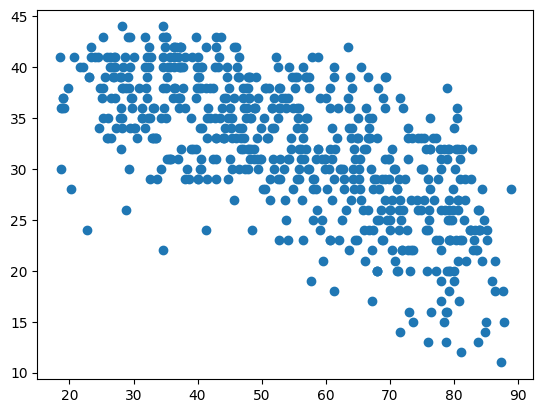

In [58]:
plt.scatter(df["age"], df["Catell_score"])

# 1. Predict global scores from every feature

In [59]:
# Remove old people (ie age > 45)

# mask = demographics["Group"] == "young adult"
# demographics = demographics[mask]
# psds = psds[mask]

In [60]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [61]:
# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [62]:
# # Standardization of the output

# scaler_output = StandardScaler()

# y_train = scaler_output.fit_transform(y_train.reshape(-1, 1))
# y_test = scaler_output.transform(y_test.reshape(-1, 1))

In [63]:
# PCA
pca = PCA(n_components=68)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [64]:
np.sum(pca.explained_variance_ratio_)

0.9132398153833308

In [65]:
# Linear Rigde Regression
lr = Lasso(alpha=0.5)
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.4553015963391156, 0.315802050208155)

MSE training :  22.962782737584295
MSE test :  36.429087201288525
Correlation test :  PearsonRResult(statistic=0.5741205170844633, pvalue=2.93232972451007e-17)


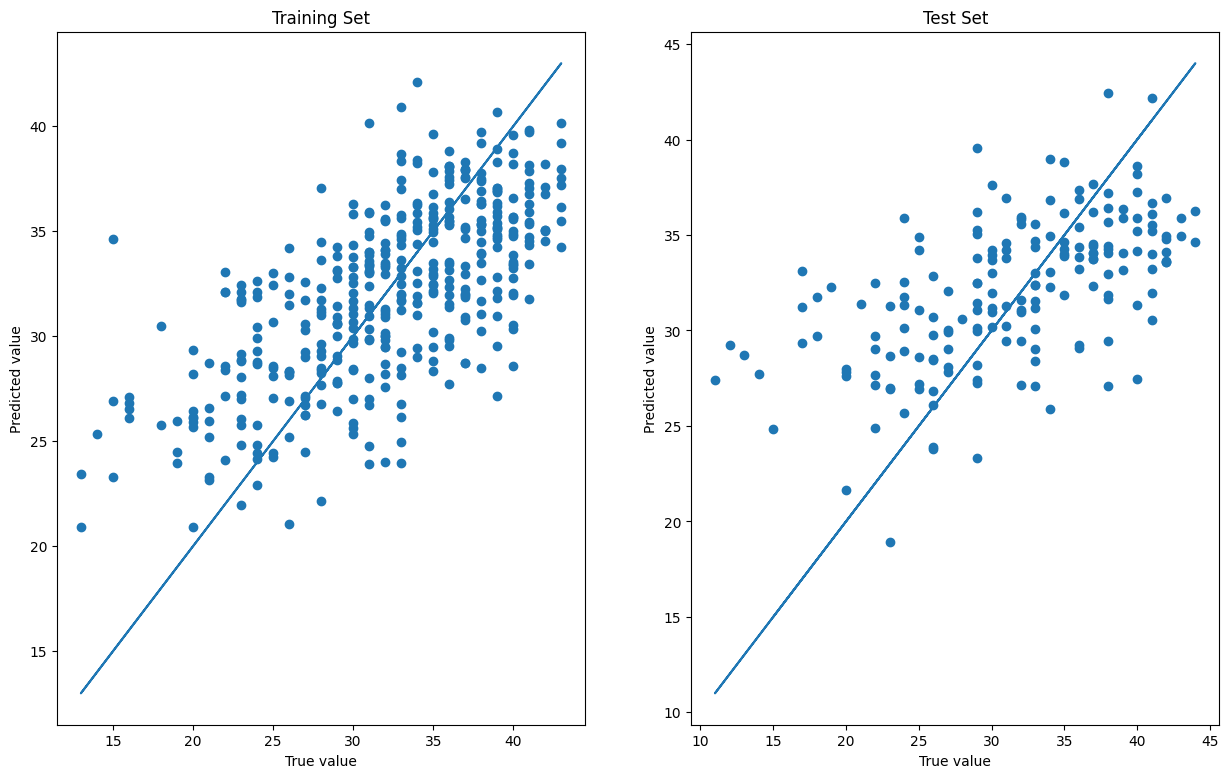

In [66]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(y_test, y_test_pred))


In [67]:
def train_and_predict(X, y, test_split = 0.2, nb_components_pca = 10, standard_input = True, standard_output = False, model = Ridge(), plot = True) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split)

    if standard_input :
        # Standardization of the input
        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

    if standard_output :
        # Standardization of the output

        scaler_output = StandardScaler()

        y_train = scaler_output.fit_transform(y_train.reshape(-1, 1))
        y_test = scaler_output.transform(y_test.reshape(-1, 1))

        y_train = y_train.reshape(-1,)
        y_test = y_test.reshape(-1,)

    if nb_components_pca :
        # PCA
        pca = PCA(n_components=50)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Linear Rigde Regression
    lr = model
    lr.fit(X_train, y_train)

    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    # Plot results
    if plot :
        _, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

        print("MSE training : ", mean_squared_error(y_train, y_train_pred))

        ax0.scatter(x=y_train, y=y_train_pred)
        ax0.plot(y_train, y_train)
        ax0.set_title("Training Set")
        ax0.set_xlabel("True value")
        ax0.set_ylabel("Predicted value")

        y_test_pred = lr.predict(X_test)
        print("MSE test : ", mean_squared_error(y_test, y_test_pred))

        ax1.scatter(x=y_test, y=y_test_pred)
        ax1.plot(y_test, y_test)
        ax1.set_title("Test Set")
        ax1.set_xlabel("True value")
        ax1.set_ylabel("Predicted value")

        plt.show()
    
    return pearsonr(y_test, y_test_pred)[0]

In [936]:
# Good result for now on:

test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Lasso(alpha=0.5)
plot = False

corr = []

for _ in tqdm(range(100), total = 100):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)

100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


In [937]:
np.mean(corr), np.std(corr)

(0.5575322255310067, 0.04912086607473273)

0.5575322255310067 0.04912086607473273


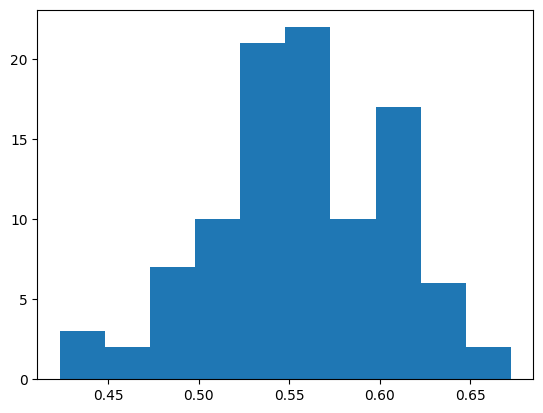

In [938]:
print(np.mean(corr), np.std(corr))
plt.hist(corr, bins = 10)
plt.show()

# Try to keep only some frequencies

In [68]:
cols_to_keep = [c for c in psds.columns if  float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= 1.0 and float(re.search("[0-9]+\.[0-9]*", c).group(0)) < 50.0]

In [69]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds[cols_to_keep]
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)


test_split = 0.2
nb_components_pca = 68
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False
corr = []

for _ in tqdm(range(10), total=10):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)


100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


0.5452939639829613 0.04037113754340438


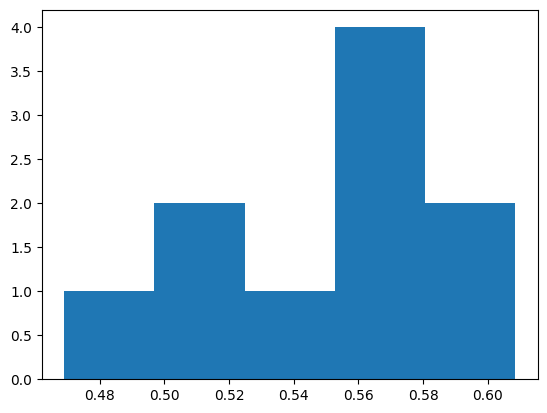

In [70]:
print(np.mean(corr), np.std(corr))
plt.hist(corr, bins = 5)
plt.show()

# With DL

In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout
from tensorflow.keras import Model

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/20


2023-05-12 14:18:41.552933: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22/22 [==============================] - 1s 38ms/step - loss: 1.5132 - mae: 1.5132 - val_loss: 0.2883 - val_mae: 0.2883
Epoch 2/20
22/22 [==============================] - 1s 25ms/step - loss: 0.6588 - mae: 0.6588 - val_loss: 0.2605 - val_mae: 0.2605
Epoch 3/20
22/22 [==============================] - 0s 23ms/step - loss: 0.4913 - mae: 0.4913 - val_loss: 0.2708 - val_mae: 0.2708
Epoch 4/20
22/22 [==============================] - 0s 22ms/step - loss: 0.4231 - mae: 0.4231 - val_loss: 0.2269 - val_mae: 0.2269
Epoch 5/20
22/22 [==============================] - 0s 22ms/step - loss: 0.4006 - mae: 0.4006 - val_loss: 0.2804 - val_mae: 0.2804
Epoch 6/20
22/22 [==============================] - 0s 22ms/step - loss: 0.3539 - mae: 0.3539 - val_loss: 0.3145 - val_mae: 0.3145
Epoch 7/20
22/22 [==============================] - 0s 22ms/step - loss: 0.3525 - mae: 0.3525 - val_loss: 0.2496 - val_mae: 0.2496
Epoch 8/20
22/22 [==============================] - 1s 24ms/step - loss: 0.3019 - mae: 0.3019 

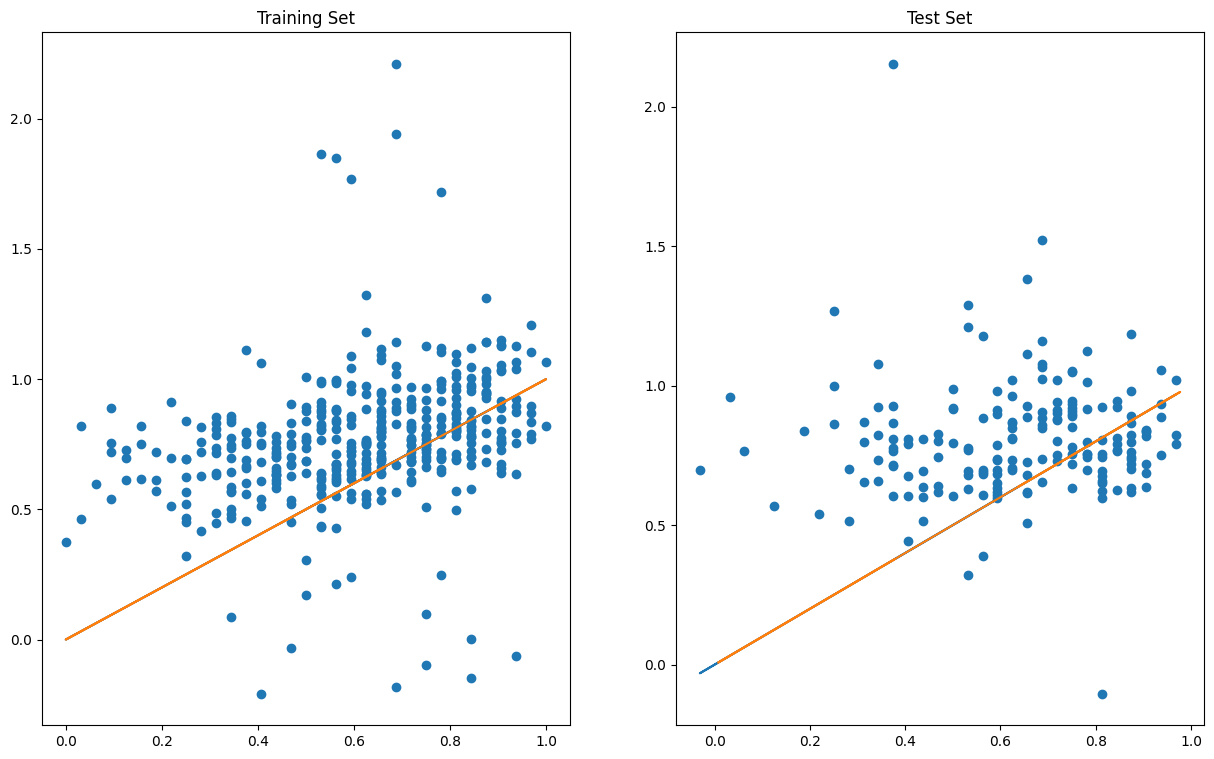

In [72]:
# To predict
col_to_predict = ["Catell_score", "age"]
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds.copy()
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


scaler_output = MinMaxScaler()

y_train = scaler_output.fit_transform(y_train)
y_test = scaler_output.transform(y_test)

# Create model
input = Input(shape=(X.shape[1]))
hidden = Dense(1024, activation = "sigmoid")(input)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)
hidden = Dense(512, activation = "sigmoid")(hidden)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)
output = Dense(2)(hidden)

model = Model(inputs = input, outputs = output)

model.compile(loss = "mae", optimizer="adam", metrics=["mae"])

#Fit model
model.fit(X_train, y_train, epochs = 20, validation_split = 0.2, batch_size=16)

# Plot results
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = model.predict(X_train)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train[:,0], y=y_train_pred[:,0])
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")

y_test_pred = model.predict(X_test)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test[:,0], y=y_test_pred[:,0])
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")

plt.show()

# New features processing

## Average per band

In [837]:
BROADBAND = (0.0, 150.0)
DELTA = (0.0, 4.0)
THETA = (4.0, 8.0)
ALPHA = (8.0, 13.0)
BETA = (13.0, 30.0)
GAMMA = (30.0, 50.0)
HIGH_GAMMA = (50.0, 150.0)

bands = [DELTA, THETA, ALPHA, BETA, GAMMA, HIGH_GAMMA]

In [838]:
avg_psds = np.zeros((psds.shape[0],6))

for k, band in enumerate(bands):
    columns_band_freq = [c for c in psds.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) < band[1]]
    psds_band = psds[columns_band_freq]
    avg_psds[:, k] = np.mean(psds_band, axis=1)

In [839]:
avg_psds = pd.DataFrame(avg_psds, columns = ["Delta", "Theta", "Alpha", "Beta", "Gamma", "High Gamma"]) 
avg_psds.head()

,Delta,Theta,Alpha,Beta,Gamma,High Gamma
0,1.273034,0.128179,0.178182,-0.498392,-2.028279,-2.708362
1,1.237832,0.319975,0.002091,-0.996203,-2.101035,-2.820252
2,1.278823,0.538073,0.230532,-0.872427,-2.056754,-2.827937
3,1.227882,0.543446,-0.005334,-0.697368,-2.467764,-3.429071
4,0.979032,0.532299,0.716635,-0.373444,-2.125706,-3.133347


In [841]:
# To predict
col_to_predict = "age"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = avg_psds.copy()
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)


test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False

for _ in tqdm(range(100), total=100):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)

np.mean(corr), np.std(corr)

100%|██████████| 100/100 [00:00<00:00, 1056.50it/s]


(0.534549009970616, 0.12735619865834483)

In [843]:
X = np.zeros((avg_psds.shape[0], avg_psds.shape[1]**2))
X[:, :6] = avg_psds.copy()

for i in range(avg_psds.shape[1]):
    for j in range(avg_psds.shape[1]):
        if i != j :
            X[i + j*6 + 6] = X[i]/X[j]

In [845]:
X

array([[ 1.27303401,  0.12817906,  0.17818223, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.23783182,  0.31997517,  0.00209147, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.27882322,  0.53807271,  0.23053231, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.70147237,  0.37935314,  0.75961557, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.7709086 , -0.0270235 ,  0.65606525, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68565382,  0.27208375,  0.6548367 , ...,  0.        ,
         0.        ,  0.        ]])

## Average per band per ROI

In [ ]:
BROADBAND = (0.0, 150.0)
DELTA = (0.0, 4.0)
THETA = (4.0, 8.0)
ALPHA = (8.0, 13.0)
BETA = (13.0, 30.0)
GAMMA = (30.0, 50.0)
HIGH_GAMMA = (50.0, 150.0)

bands = [DELTA, THETA, ALPHA, BETA, GAMMA, HIGH_GAMMA]

In [831]:
avg_psds = np.zeros((psds.shape[0],6*len(ROIs)))

for k, band in enumerate(bands):
    columns_band_freq = [c for c in psds.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) < band[1]]
    for l, ROI in enumerate(ROIs) :
        columns_ROI = [c for c in columns_band_freq if ROI in c]
        psds_band_ROI = psds[columns_ROI]
        avg_psds[:, k + l*6] = np.mean(psds_band_ROI, axis=1)

In [836]:
# To predict
col_to_predict = "age"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = avg_psds.copy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)


test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False

for _ in tqdm(range(100), total=100):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)

np.mean(corr), np.std(corr)

100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


(0.5814623398568872, 0.10592879015529226)

# Try to see if same results reducing to only highly heritable features

**To continue**

In [74]:
# Import ICC for DK

path = "Results_Log_DK/ICC_and_Heritability/ICC.csv"
ICC = pd.read_csv(path, index_col=0)
ICC = ICC.drop(columns=[str(150.0)]) # Because not in CamCAN

In [75]:
ICC_flatten = {roi + "_" + str(freq) : ICC.loc[roi, freq] for roi in ICC.index for freq in ICC.columns}

In [76]:
nb_features = 1000
top_h = sorted(ICC_flatten, key=ICC_flatten.get, reverse=True)[:nb_features]
bottom_h = sorted(ICC_flatten, key=ICC_flatten.get, reverse=True)[-nb_features:]
random_h = np.random.choice(list(ICC_flatten.keys()), size = nb_features)

In [77]:
top_h[:5]

['superiortemporal R_9.5',
 'middletemporal R_9.5',
 'superiortemporal R_9.0',
 'superiortemporal R_10.0',
 'middletemporal R_10.0']

In [78]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds[bottom_h]
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [79]:
# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [80]:
# Linear Rigde Regression
lr = Lasso(alpha=0.4)
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.238439767591769, 0.20603840859721168)

MSE training :  33.58024160896539
MSE test :  38.4566194046622
Pearson correlation test :  PearsonRResult(statistic=0.5011697964952541, pvalue=6.687712862424963e-13)
ICC test :  0.2990450291502763


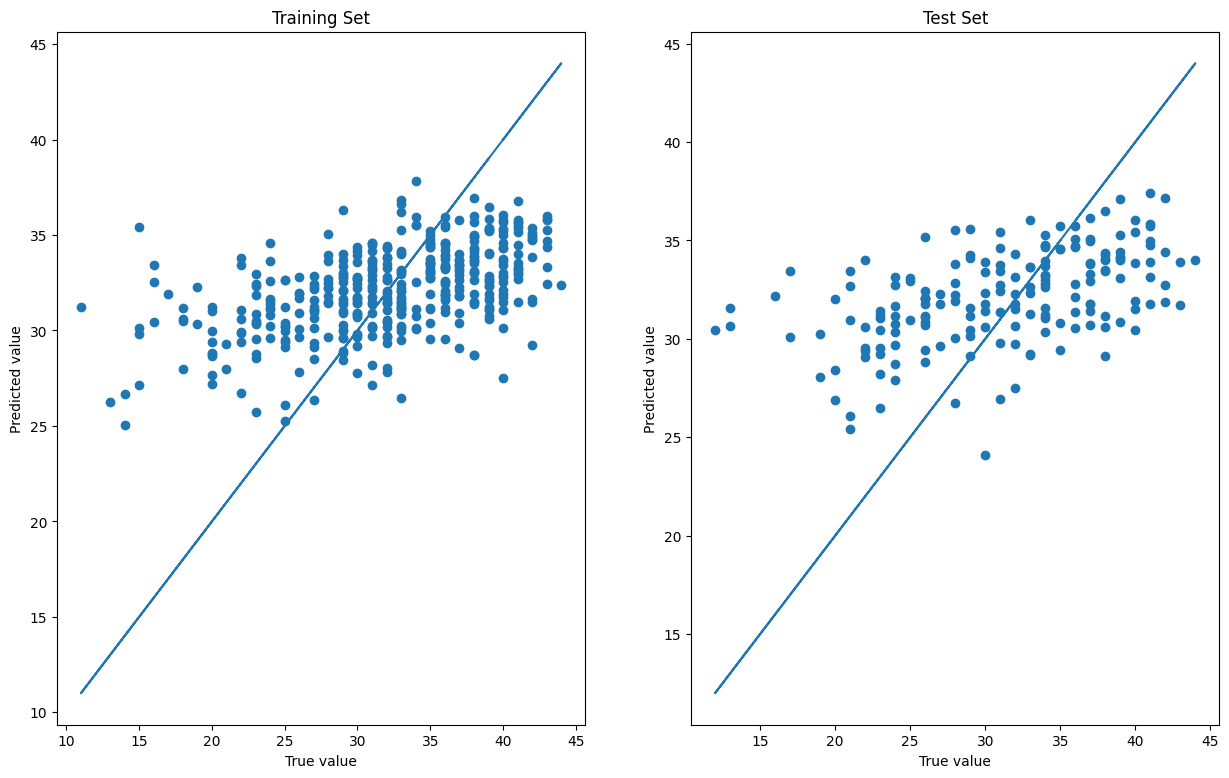

In [81]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Pearson correlation test : ", pearsonr(y_test, y_test_pred))
print("ICC test : ", icc_evaluation(y_test, y_test_pred))


In [82]:
def icc_evaluation(y_pred, y_true):

    n_subs = y_pred.shape[0] # Change here to get number of participants! 
    n_measurements = 2

    n = n_subs
    k = n_measurements
    df_b = n-1
    df_w = n*(k-1)

    x = np.concatenate([y_true.reshape(-1, 1), y_pred.reshape(-1, 1)], axis = 1)
    x_w_mean = x.mean(axis = 1)
    x_g_mean = x.mean()
    ss_t = ((x - x_g_mean) ** 2).sum()
    ss_w = ((x - np.expand_dims(x_w_mean, axis = 1)) ** 2).sum()
    ss_b = ss_t - ss_w
    ms_b = ss_b / df_b
    ms_w = ss_w / df_w
    icc_score = (ms_b - ms_w) / (ms_b + ((k-1)*ms_w))

    return icc_score

In [83]:
icc_evaluation(y_test, y_test_pred)

0.2990450291502763

# Benchmark with GridSearch

## Lasso and Ridge

In [26]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [27]:
# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [28]:
score = make_scorer(icc, greater_is_better=True)

### Lasso

In [ ]:
parameters = {'fit_intercept':[True, False], 'alpha':[0.01, 0.1, 0.4, 0.75], "tol" : [ 1e-2, 1e-4], "max_iter" : [1000]}
lasso = Lasso()
lr = GridSearchCV(lasso, parameters, cv = 5, scoring=score)
lr.fit(X_train, y_train)


In [366]:
print(lr.best_params_)

{'alpha': 0.1, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.01}

In [373]:
pd.DataFrame(lr.cv_results_).sort_values(by = ["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1.975217,0.059768,0.019881,0.007989,0.1,True,1000,0.01,"{'alpha': 0.1, 'fit_intercept': True, 'max_ite...",0.460392,0.503082,0.485263,0.486431,0.518113,0.490656,0.019345,1
5,0.412345,0.038629,0.119185,0.046939,0.1,True,1000,0.0001,"{'alpha': 0.1, 'fit_intercept': True, 'max_ite...",0.460392,0.503082,0.485263,0.486431,0.518113,0.490656,0.019345,1
8,0.207042,0.105247,0.042522,0.014827,0.4,True,1000,0.01,"{'alpha': 0.4, 'fit_intercept': True, 'max_ite...",0.483099,0.540896,0.439921,0.481780,0.469947,0.483128,0.032801,3
9,0.411899,0.165989,0.031413,0.030123,0.4,True,1000,0.0001,"{'alpha': 0.4, 'fit_intercept': True, 'max_ite...",0.487616,0.534088,0.434324,0.480269,0.465342,0.480328,0.032509,4
12,0.095565,0.063505,0.020419,0.007174,0.75,True,1000,0.01,"{'alpha': 0.75, 'fit_intercept': True, 'max_it...",0.439301,0.480330,0.393417,0.417292,0.418010,0.429670,0.029198,5
13,0.176719,0.030809,0.027933,0.012871,0.75,True,1000,0.0001,"{'alpha': 0.75, 'fit_intercept': True, 'max_it...",0.442119,0.474990,0.396611,0.412603,0.420780,0.429421,0.027099,6
0,2.294850,0.136471,0.013534,0.006160,0.01,True,1000,0.01,"{'alpha': 0.01, 'fit_intercept': True, 'max_it...",0.265940,0.399762,0.337428,0.319636,0.379932,0.340540,0.047055,7
1,0.489466,0.036780,0.104084,0.068894,0.01,True,1000,0.0001,"{'alpha': 0.01, 'fit_intercept': True, 'max_it...",0.265940,0.399762,0.337428,0.319636,0.379932,0.340540,0.047055,7
2,2.175912,0.052945,0.035170,0.046489,0.01,False,1000,0.01,"{'alpha': 0.01, 'fit_intercept': False, 'max_i...",-0.443529,-0.328909,-0.322359,-0.258315,-0.278472,-0.326317,0.064303,9
3,0.503450,0.045727,0.171602,0.040875,0.01,False,1000,0.0001,"{'alpha': 0.01, 'fit_intercept': False, 'max_i...",-0.443529,-0.328909,-0.322359,-0.258315,-0.278472,-0.326317,0.064303,9


In [31]:
parameters = {'fit_intercept':[True], 'alpha':[0.1, 0.25, 0.4, 0.75], "tol" : [ 1e-4], "max_iter" : [1000]}
lasso = Lasso()
lr = GridSearchCV(lasso, parameters, cv = 5, scoring=score)
lr.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.25, 0.4, 0.75],
                         'fit_intercept': [True], 'max_iter': [1000],
                         'tol': [0.0001]},
             scoring=make_scorer(icc))

In [32]:
pd.DataFrame(lr.cv_results_).sort_values(by = ["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.856157,0.177503,0.030084,0.009187,0.25,True,1000,0.0001,"{'alpha': 0.25, 'fit_intercept': True, 'max_it...",0.612136,0.340673,0.364851,0.551771,0.484565,0.470799,0.104766,1
0,1.911580,0.070470,0.021015,0.004606,0.1,True,1000,0.0001,"{'alpha': 0.1, 'fit_intercept': True, 'max_ite...",0.601823,0.305196,0.367547,0.532648,0.510960,0.463635,0.109940,2
2,0.767906,0.168099,0.025071,0.004277,0.4,True,1000,0.0001,"{'alpha': 0.4, 'fit_intercept': True, 'max_ite...",0.578446,0.331811,0.384876,0.551727,0.428458,0.455064,0.095281,3
3,0.607814,0.122240,0.069412,0.077744,0.75,True,1000,0.0001,"{'alpha': 0.75, 'fit_intercept': True, 'max_it...",0.463564,0.280754,0.348562,0.429753,0.325749,0.369676,0.067390,4


MSE training :  18.84210629167926
MSE test :  31.56394745153553
Correlation test :  PearsonRResult(statistic=0.5726840404668162, pvalue=3.661539597409687e-17)
ICC test :  0.5013250823516554


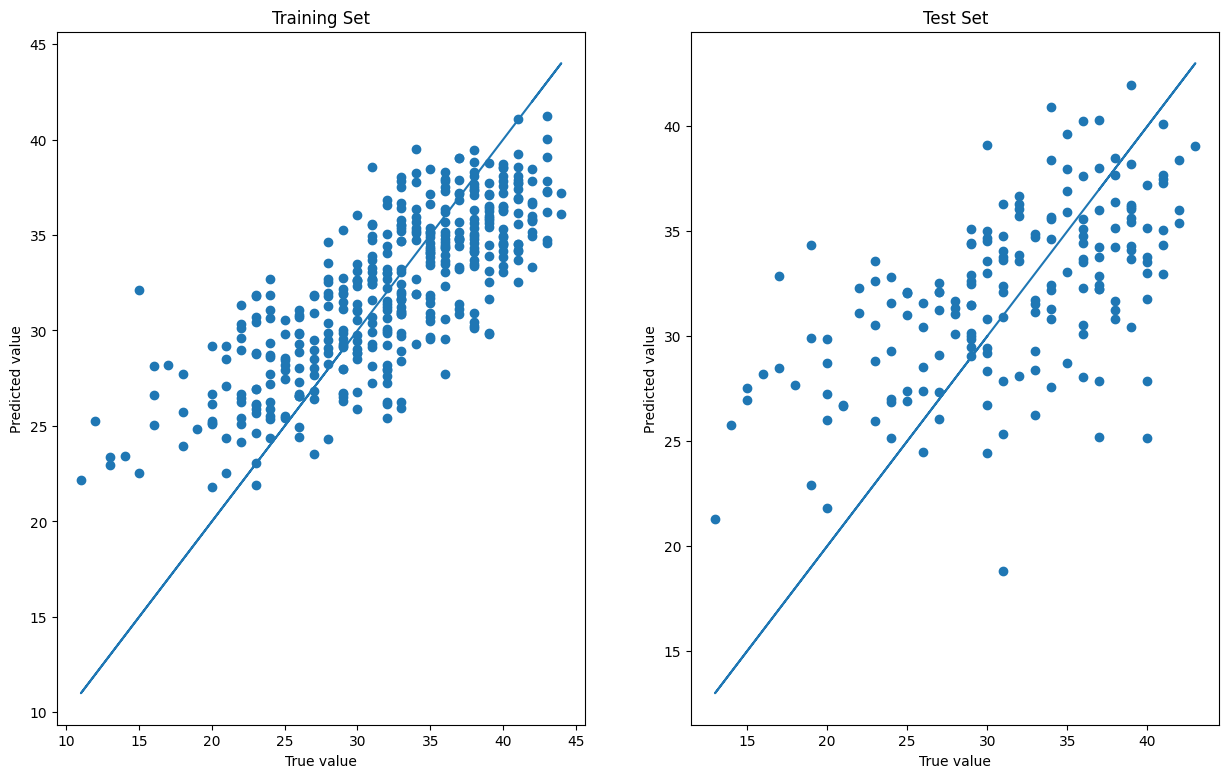

In [33]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(y_test, y_test_pred))
print("ICC test : ", icc_evaluation(y_test, y_test_pred))


### Ridge

In [388]:
parameters = {'fit_intercept':[True, False], 'alpha':[50, 75, 100, 125], "tol" : [ 1e-4], "max_iter" : [1000], "solver" : ["auto"]}
lasso = Ridge()
lr = GridSearchCV(lasso, parameters, cv = 5, scoring=score)
lr.fit(X_train, y_train)

print(lr.best_params_)
pd.DataFrame(lr.cv_results_).sort_values(by = ["rank_test_score"])

{'alpha': 75, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'auto', 'tol': 0.0001}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_max_iter,param_solver,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.511147,0.031230,0.015030,0.013130,75,True,1000,auto,0.0001,"{'alpha': 75, 'fit_intercept': True, 'max_iter...",0.478734,0.542548,0.507829,0.504481,0.529156,0.512549,0.021939,1
4,0.482067,0.050043,0.006646,0.004950,100,True,1000,auto,0.0001,"{'alpha': 100, 'fit_intercept': True, 'max_ite...",0.484034,0.545106,0.501630,0.502880,0.521630,0.511056,0.020770,2
0,0.433916,0.071063,0.019580,0.010509,50,True,1000,auto,0.0001,"{'alpha': 50, 'fit_intercept': True, 'max_iter...",0.467808,0.532646,0.512593,0.501271,0.537499,0.510363,0.025026,3
6,0.420351,0.098573,0.007006,0.003500,125,True,1000,auto,0.0001,"{'alpha': 125, 'fit_intercept': True, 'max_ite...",0.486501,0.544294,0.495239,0.499419,0.514861,0.508063,0.020312,4
1,0.466534,0.061450,0.021801,0.014050,50,False,1000,auto,0.0001,"{'alpha': 50, 'fit_intercept': False, 'max_ite...",-0.677936,-0.721990,-0.606528,-0.579793,-0.675749,-0.652399,0.051800,5
3,0.464945,0.020728,0.024705,0.016505,75,False,1000,auto,0.0001,"{'alpha': 75, 'fit_intercept': False, 'max_ite...",-0.691770,-0.744063,-0.628473,-0.621549,-0.699483,-0.677068,0.046154,6
5,0.477102,0.051368,0.008952,0.007561,100,False,1000,auto,0.0001,"{'alpha': 100, 'fit_intercept': False, 'max_it...",-0.698422,-0.753683,-0.637974,-0.646877,-0.710541,-0.689500,0.042693,7
7,0.404778,0.085402,0.007689,0.012264,125,False,1000,auto,0.0001,"{'alpha': 125, 'fit_intercept': False, 'max_it...",-0.702097,-0.758437,-0.642459,-0.663682,-0.716601,-0.696655,0.040667,8


MSE training :  98.8967124914634
MSE test :  240.22024638913302
Correlation test :  PearsonRResult(statistic=0.5899862385527561, pvalue=1.886947195717016e-18)
ICC test :  0.5403686229394637


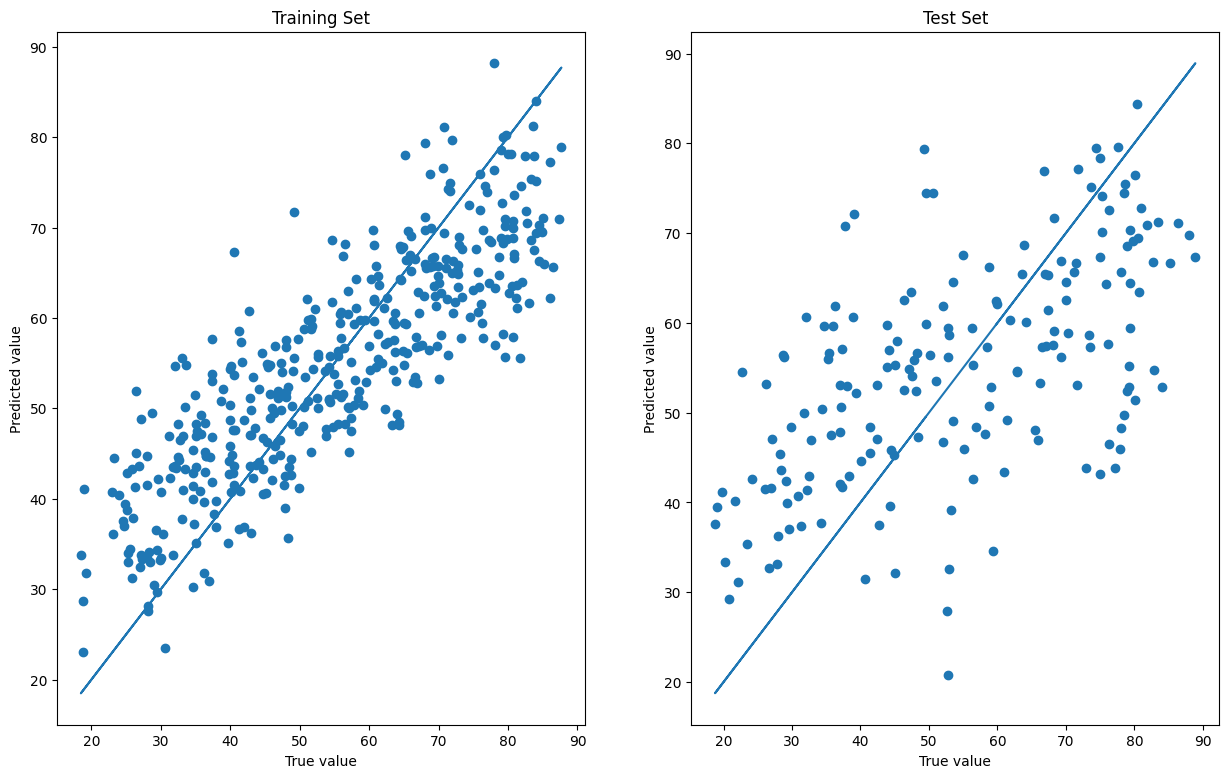

In [389]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(y_test, y_test_pred))
print("ICC test : ", icc_evaluation(y_test, y_test_pred))


## Other models

# Comparison features

In [11]:
# Import icc for DK

path = "Results_Log_DK/ICC_and_Heritability/icc_mean.csv"
icc = pd.read_csv(path, index_col=0)
icc = icc.drop(columns=[str(150.0)]) # Because not in CamCAN

# Features
icc_flatten = {roi + "_" + str(freq) : icc.loc[roi, freq] for roi in icc.index for freq in icc.columns}

ICCs = {}
for nb_features in [10, 100, 300, 600, 1000]:

    # Select features
    top_h = sorted(icc_flatten, key=icc_flatten.get, reverse=True)[:nb_features]
    bottom_h = sorted(icc_flatten, key=icc_flatten.get, reverse=True)[-nb_features:]
    random_h = np.random.choice(list(icc_flatten.keys()), size = nb_features)

    for name, choose_feature in {"top_h" : top_h, "bottom_h": bottom_h, "random_h": random_h}.items():

        # Bootstrapping
        ICCs[name + "_" + str(nb_features)] = []
        for _ in tqdm(range(200), total = 200):

            # To predict
            col_to_predict = "Catell_score"
            y = demographics[col_to_predict]
            y = y.to_numpy()   

            # Features
            if name == "random_h":
                choose_feature = np.random.choice(list(icc_flatten.keys()), size = nb_features)

            X = psds[choose_feature]
            X = X.to_numpy()

            # Remove Nan Values
            index = np.where(np.isnan(y) == True)[0]
            X = np.delete(X, index, axis=0)
            y = np.delete(y, index, axis=0)

            # Remove the outliers, ex here one with a score of 0
            index = np.where(y == 0)[0]
            X = np.delete(X, index, axis=0)
            y = np.delete(y, index, axis=0)

            # Train-Test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

            # Standardization of the input
            scaler = StandardScaler()

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)# Linear Rigde Regression
            
            lr = Lasso(alpha=0.25)
            lr.fit(X_train, y_train)

            y_test_pred = lr.predict(X_test)
            icc_score = icc_evaluation(y_test, y_test_pred)
            ICCs[name + "_" + str(nb_features)].append(icc_score)



100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


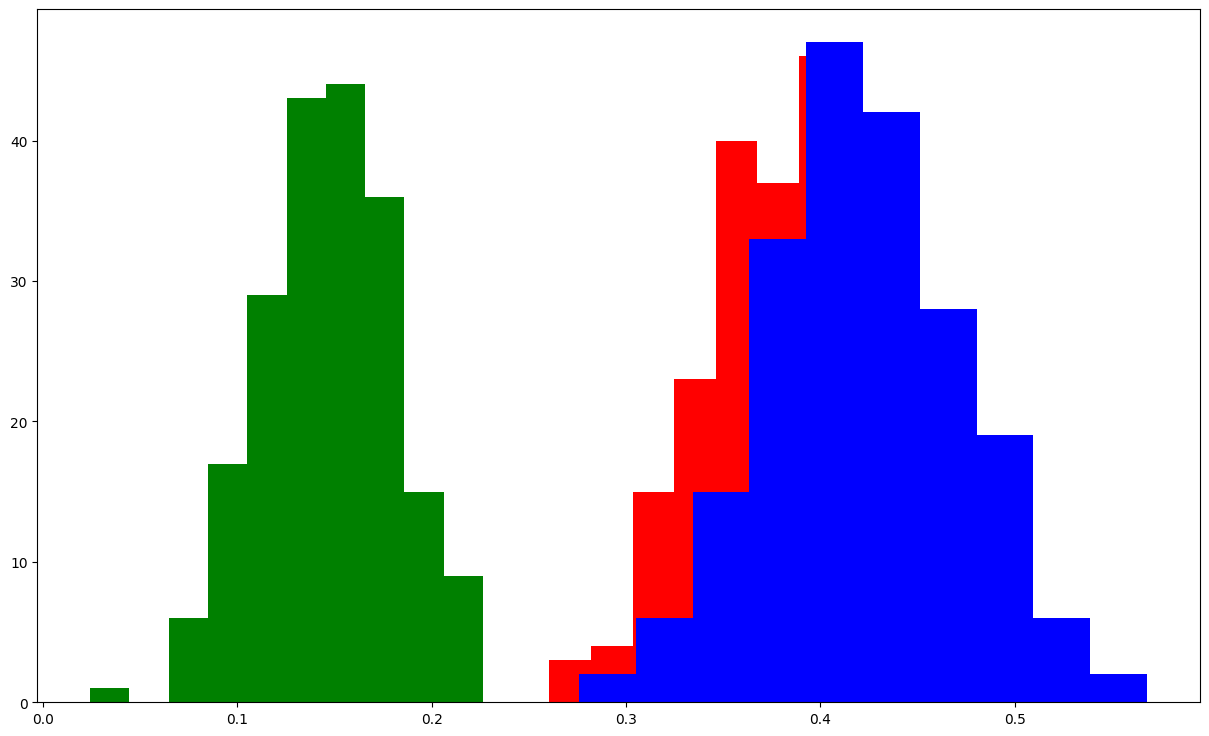

In [13]:
plt.figure(figsize=(15, 9))
           
plt.hist(ICCs["top_h_300"], color = "red")
plt.hist(ICCs["random_h_300"], color = "blue")
plt.hist(ICCs["bottom_h_300"], color = "green")

plt.show()

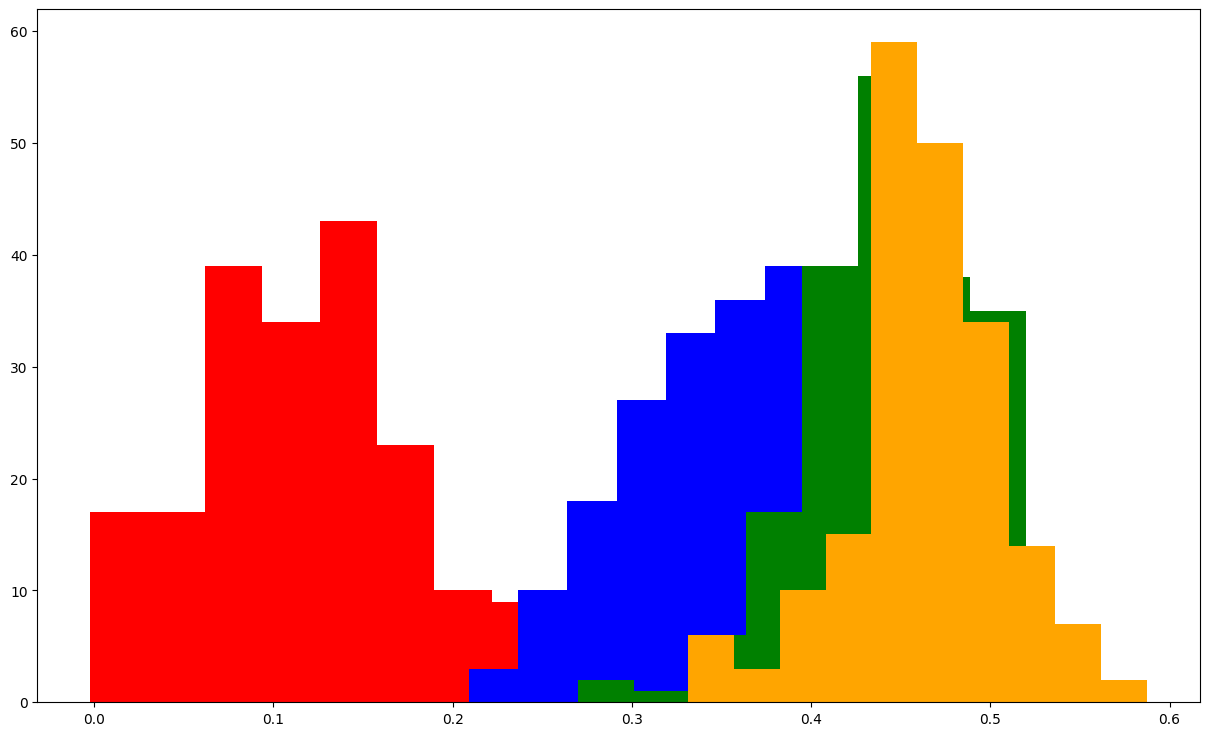

In [15]:
plt.figure(figsize=(15, 9))
           
plt.hist(ICCs["random_h_10"], color = "red")
plt.hist(ICCs["random_h_100"], color = "blue")
plt.hist(ICCs["random_h_600"], color = "green")
plt.hist(ICCs["random_h_1000"], color = "orange")


plt.show()

# New model prediction age and then using this prediction

In [84]:
# To predict
cols_to_predict = ["age", "Catell_score"]
y = demographics[cols_to_predict]
y = y.to_numpy()

# Features
X = psds.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

y_train_age = y_train[:, 0]
y_test_age = y_test[:, 0]
y_train_score = y_train[:, 1]
y_test_score = y_test[:, 1]

In [85]:
# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [86]:
# Linear Rigde Regression
lr_age = Lasso(alpha=0.3)
lr_age.fit(X_train, y_train_age)

lr_age.score(X_train, y_train_age), lr_age.score(X_test, y_test_age)

(0.9006472303125724, 0.7063748357080576)

MSE training :  31.605891674706967
MSE test :  105.88257774035273
Pearson correlation test :  PearsonRResult(statistic=0.8476549703482004, pvalue=3.727804066905542e-51)
ICC test :  0.8197148136256956


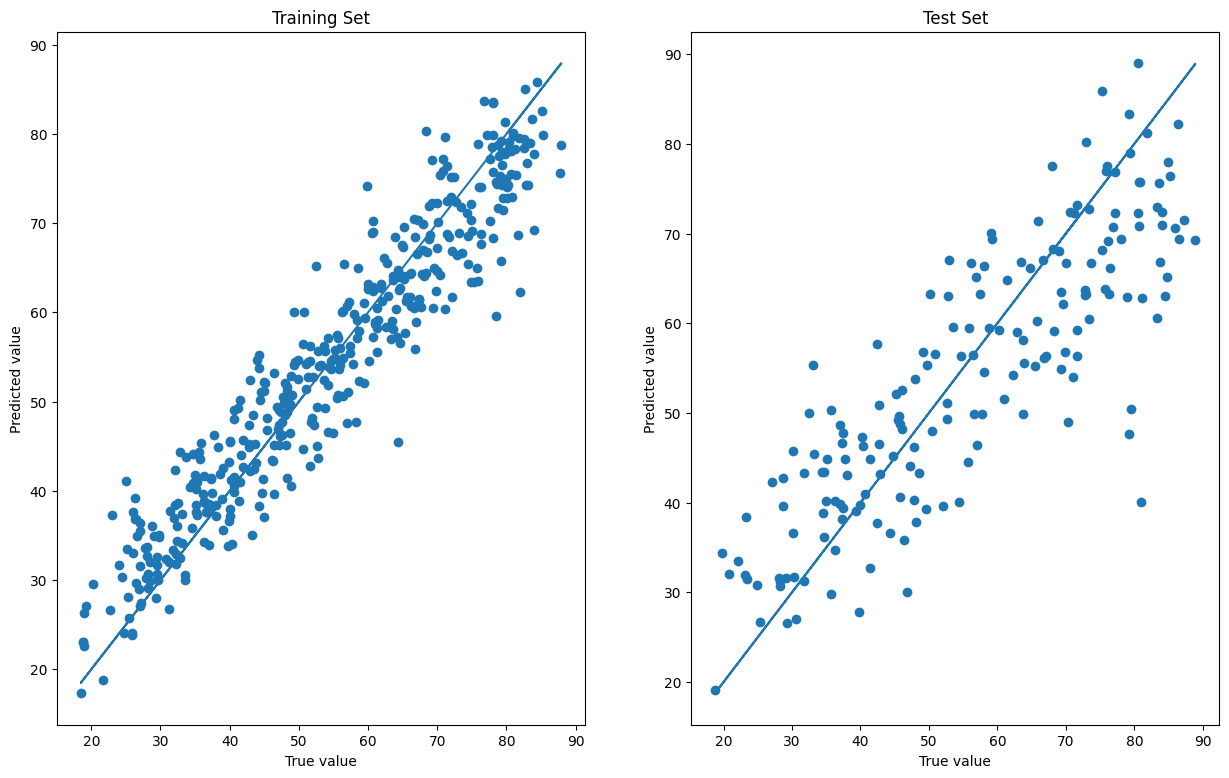

In [87]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred_age = lr_age.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train_age, y_train_pred_age))

ax0.scatter(x=y_train_age, y=y_train_pred_age)
ax0.plot(y_train_age, y_train_age)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred_age = lr_age.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test_age, y_test_pred_age))

ax1.scatter(x=y_test_age, y=y_test_pred_age)
ax1.plot(y_test_age, y_test_age)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Pearson correlation test : ", pearsonr(y_test_age, y_test_pred_age))
print("ICC test : ", icc_evaluation(y_test_age, y_test_pred_age))


In [88]:
# And now use this as an additional feature for the final prediction
scaler = StandardScaler()

y_train_pred_age = scaler.fit_transform(y_train_pred_age.reshape(-1, 1))
y_test_pred_age = scaler.fit_transform(y_test_pred_age.reshape(-1, 1))

X_train = np.concatenate([X_train, y_train_pred_age], axis = 1)
X_test = np.concatenate([X_test, y_test_pred_age], axis = 1)

In [89]:
# Linear Rigde Regression
lr_score = Lasso(alpha=0.35)
lr_score.fit(X_train, y_train_score)

lr_score.score(X_train, y_train_score), lr_score.score(X_test, y_test_score)

(0.5090793857372911, 0.3360136168628354)

MSE training :  20.460542630000575
MSE test :  36.0658854425451
Pearson correlation test :  PearsonRResult(statistic=0.5920783124003968, pvalue=1.661992718217574e-18)
ICC test :  0.48992129123369116


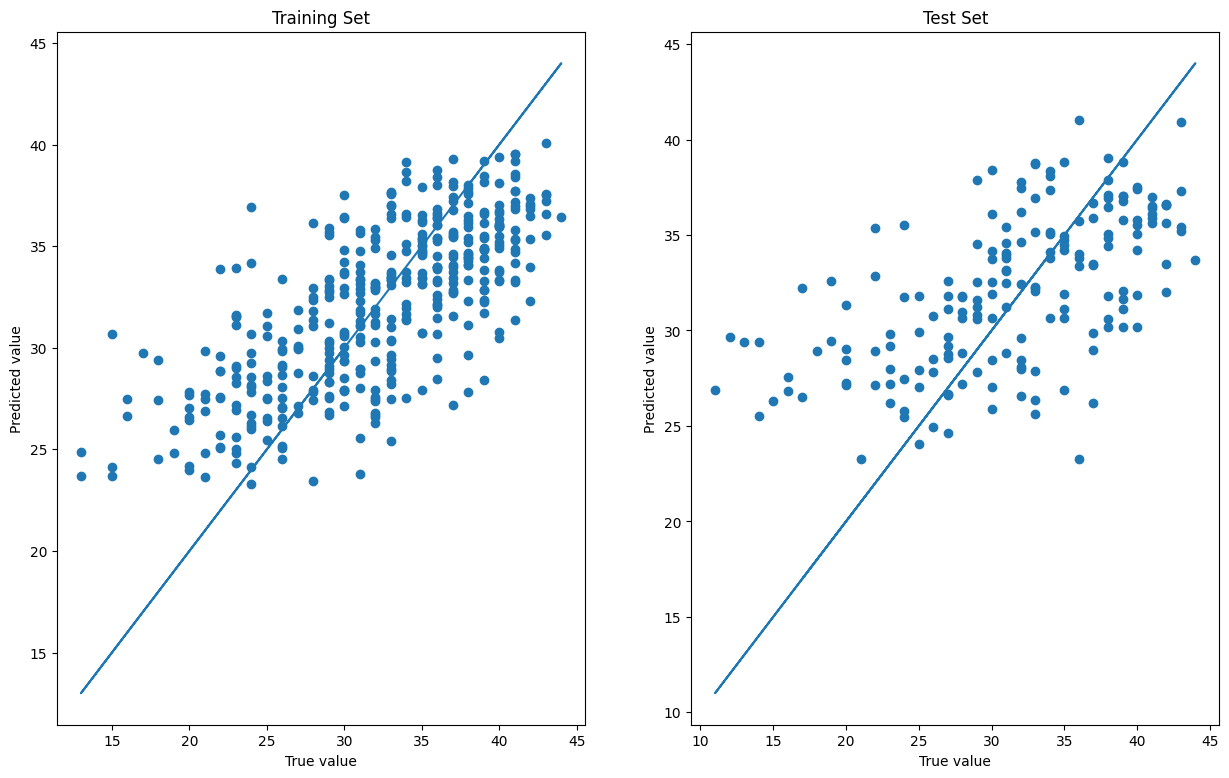

In [90]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred_score = lr_score.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train_score, y_train_pred_score))

ax0.scatter(x=y_train_score, y=y_train_pred_score)
ax0.plot(y_train_score, y_train_score)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred_score = lr_score.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test_score, y_test_pred_score))

ax1.scatter(x=y_test_score, y=y_test_pred_score)
ax1.plot(y_test_score, y_test_score)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Pearson correlation test : ", pearsonr(y_test_score, y_test_pred_score))
print("ICC test : ", icc_evaluation(y_test_score, y_test_pred_score))


In [ ]:
# To predict
cols_to_predict = ["age", "Catell_score"]
y = demographics[cols_to_predict]
y = y.to_numpy()

# Features
X = psds.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

iccs = []
for _ in tqdm(range(100), total = 100):
    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    y_train_age = y_train[:, 0]
    y_test_age = y_test[:, 0]
    y_train_score = y_train[:, 1]
    y_test_score = y_test[:, 1]

    # Standardization of the input
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # Linear Rigde Regression
    lr_age = Lasso(alpha=0.3)
    lr_age.fit(X_train, y_train_age)

    y_train_pred_age = lr_age.predict(X_train)
    y_test_pred_age = lr_age.predict(X_test)

    # And now use this as an additional feature for the final prediction
    scaler = StandardScaler()

    y_train_pred_age = scaler.fit_transform(y_train_pred_age.reshape(-1, 1))
    y_test_pred_age = scaler.fit_transform(y_test_pred_age.reshape(-1, 1))

    X_train = np.concatenate([X_train, y_train_pred_age], axis = 1)
    X_test = np.concatenate([X_test, y_test_pred_age], axis = 1)

    # Linear Rigde Regression
    lr_score = Lasso(alpha=0.35)
    lr_score.fit(X_train, y_train_score)


    y_train_pred_score = lr_score.predict(X_train)
    y_test_pred_score = lr_score.predict(X_test)

    iccs.append(icc_evaluation(y_test_score, y_test_pred_score))



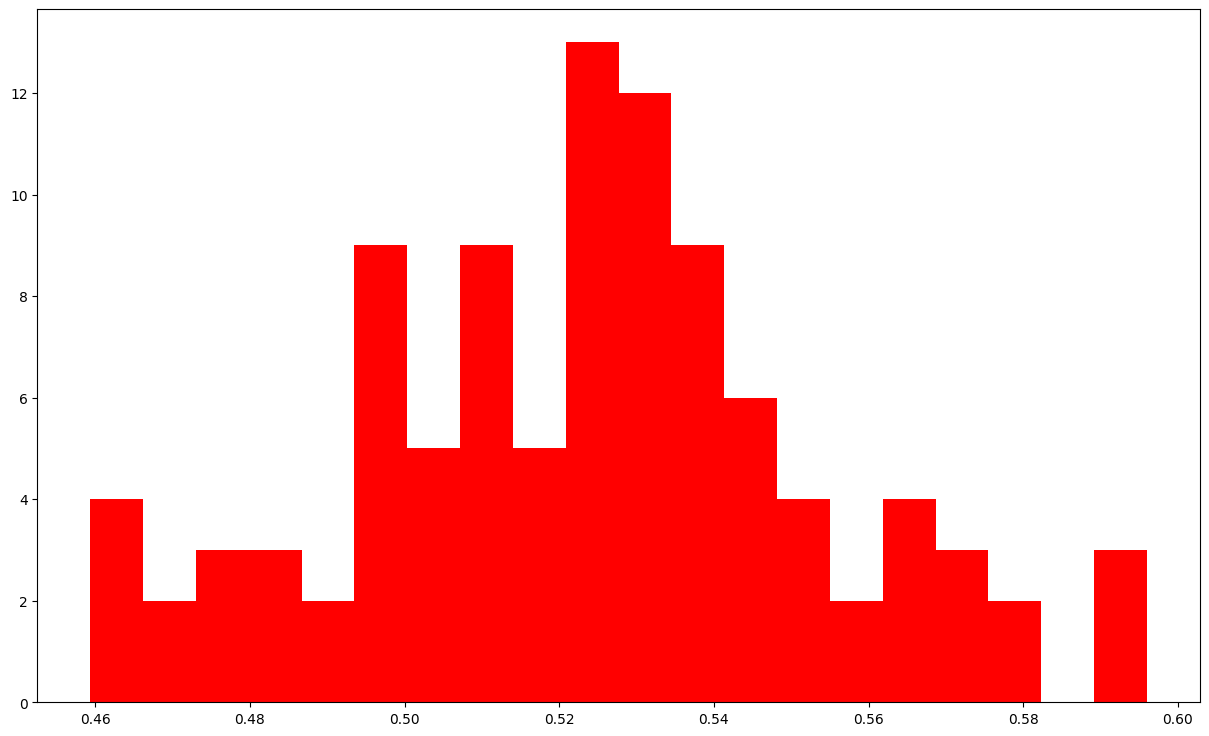

In [49]:
plt.figure(figsize=(15, 9))
           
plt.hist(iccs, color = "red", bins = 20)

plt.show()

# Select different quality of features

In [100]:
# Import icc for DK

path = "Results_Log_DK/ICC_and_Heritability/icc.csv"
icc = pd.read_csv(path, index_col=0)
icc = icc.drop(columns=[str(150.0)]) # Because not in CamCAN

# Features
icc_flatten = {roi + "_" + str(freq) : icc.loc[roi, freq] for roi in icc.index for freq in icc.columns}

ICCs = {}
features_cut = np.linspace(0, len(icc_flatten), 11)

for i in range(len(features_cut)-1):

    # Select features
    begin = int(features_cut[i])
    end = int(features_cut[i+1])
    choosen_feature = sorted(icc_flatten, key=icc_flatten.get, reverse=True)[begin:end]

    # To predict
    col_to_predict = "Catell_score"
    y = demographics[col_to_predict]
    y = y.to_numpy()   

    # Features
    X = psds[choosen_feature]
    X = X.to_numpy()

    # Remove Nan Values
    index = np.where(np.isnan(y) == True)[0]
    X = np.delete(X, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove the outliers, ex here one with a score of 0
    index = np.where(y == 0)[0]
    X = np.delete(X, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Bootstrapping
    ICCs[i] = []
    for _ in tqdm(range(100), total = 100):

        # Train-Test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        # Standardization of the input
        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)# Linear Rigde Regression
        
        lr = Lasso(alpha=0.25)
        lr.fit(X_train, y_train)

        y_test_pred = lr.predict(X_test)
        icc_score = icc_evaluation(y_test, y_test_pred)
        ICCs[i].append(icc_score)

ICCs = pd.DataFrame(ICCs)
ICCs = pd.DataFrame(ICCs.stack()).reset_index().rename(columns={"level_1":"Level", 0:"value"}).drop(columns=["level_0"])

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


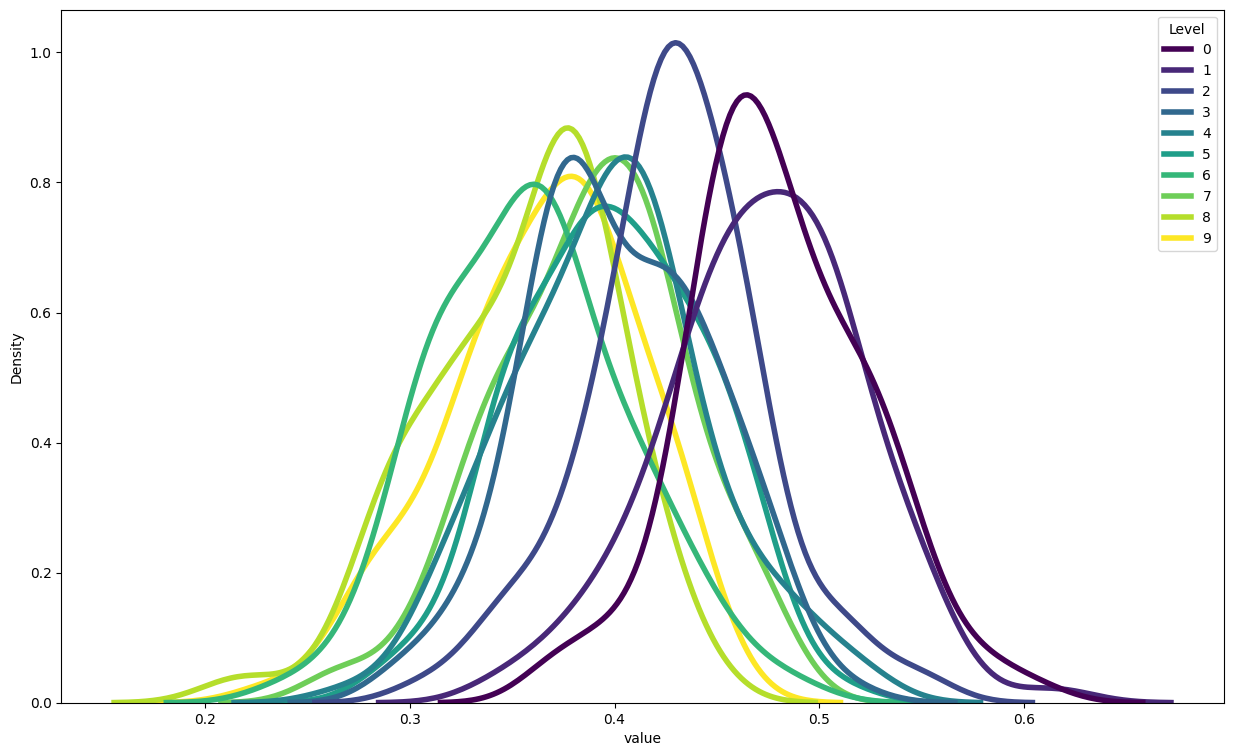

In [102]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data = ICCs, x = "value", hue = "Level", palette=sns.color_palette("viridis", as_cmap=True), linewidth=4)
plt.show()

# Ideas

- Use ICC instead of Pearson because we want X = y
- Benchmark models with GridSearch for the moment
- Create model which predicts age and then second one using this prediction to predict new score
- Run bootstrapping/ Model multi times to collect scores
- Also do it with ICC
- Transition by 10% from best to worst
- Train on CAMCan and test on HCP, remove site effect5